In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
import os

DATA_DIR = Path("data/").resolve()

EXPERIMENT_NAME = "01_xgboost-target-encoding"

EXPERIMENT_DIR = Path(f"experiments/{EXPERIMENT_NAME}").resolve()

os.makedirs(EXPERIMENT_DIR, exist_ok=True)

In [6]:
training_set = pd.read_csv(DATA_DIR / "training_set.csv", delimiter=",")

training_set_back = training_set.copy()

# Fix outliers. Looks like an error in data entry

training_set.loc[training_set.D3D > 10000, "D3D"] = training_set.D3D / 1000
training_set.loc[training_set.D2D > 10000, "D2D"] = training_set.D2D / 1000
training_set.loc[training_set.AZ > 1000, "AZ"] = training_set.AZ / 1000

### Preprocessing

In [7]:
id_features = ["ID_FILA", "ID_EVENTO"]

In [8]:
categorical_features = [
    "CAMPO",
    "FLUIDO",
    "HIJO",
    "PAD_HIJO",
    "PADRE",
    "LINEAMIENTO",
    "ESTADO"
]

In [9]:
training_set = training_set.drop(labels=id_features, axis=1)

### Target Encoding + Additive smoothing

In [10]:
smooth_means = {}

In [11]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Store the smoothed mean for each value of `by`
    smooth_means[smooth.index.name] = smooth.to_dict()

In [12]:
for c in categorical_features:
    calc_smooth_mean(training_set, by=c, on='delta_WHP', m=1000)

In [13]:
for c in categorical_features:
    training_set[c] = training_set[c].map(smooth_means[c])

### XGB Regressor

In [14]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26178 entries, 0 to 26177
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CAMPO        26178 non-null  float64
 1   FLUIDO       26178 non-null  float64
 2   PAD_HIJO     26178 non-null  float64
 3   HIJO         26178 non-null  float64
 4   ETAPA_HIJO   26178 non-null  int64  
 5   PADRE        26178 non-null  float64
 6   D3D          26178 non-null  float64
 7   D2D          26178 non-null  float64
 8   DZ           26178 non-null  float64
 9   AZ           26178 non-null  float64
 10  #_BARRERAS   26178 non-null  float64
 11  LINEAMIENTO  26178 non-null  float64
 12  WHP_i        26178 non-null  float64
 13  delta_WHP    26178 non-null  float64
 14  ESTADO       26178 non-null  float64
dtypes: float64(14), int64(1)
memory usage: 3.0 MB


In [15]:
df_train = training_set.sample(frac=0.75)
df_test = training_set[~training_set.index.isin(df_train.index)]

len(df_train), len(df_test)

(19634, 6544)

In [16]:
TARGET = "delta_WHP"

X_train = df_train.drop(TARGET, axis=1)
y_train = df_train[TARGET]

X_test = df_test.drop(TARGET, axis=1)
y_test = df_test[TARGET]

In [17]:
reg = xgb.XGBRegressor(
    n_estimators=1000,
    objective="reg:squarederror",
    early_stopping_rounds=50,
    learning_rate=0.1,
)

In [18]:
reg.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
)

[0]	validation_0-rmse:6.96673	validation_1-rmse:8.17253
[1]	validation_0-rmse:6.66006	validation_1-rmse:7.92055
[2]	validation_0-rmse:6.40817	validation_1-rmse:7.72826
[3]	validation_0-rmse:6.18722	validation_1-rmse:7.55435
[4]	validation_0-rmse:5.99401	validation_1-rmse:7.41317
[5]	validation_0-rmse:5.81450	validation_1-rmse:7.28854
[6]	validation_0-rmse:5.65551	validation_1-rmse:7.20626
[7]	validation_0-rmse:5.51635	validation_1-rmse:7.11086
[8]	validation_0-rmse:5.37120	validation_1-rmse:7.04234
[9]	validation_0-rmse:5.24433	validation_1-rmse:6.98434
[10]	validation_0-rmse:5.11648	validation_1-rmse:6.90757
[11]	validation_0-rmse:5.02094	validation_1-rmse:6.86158
[12]	validation_0-rmse:4.91954	validation_1-rmse:6.80068
[13]	validation_0-rmse:4.84602	validation_1-rmse:6.75644
[14]	validation_0-rmse:4.77533	validation_1-rmse:6.70971
[15]	validation_0-rmse:4.70059	validation_1-rmse:6.67759
[16]	validation_0-rmse:4.62344	validation_1-rmse:6.65191
[17]	validation_0-rmse:4.55052	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [34]:
reg.save_model(EXPERIMENT_DIR / "xgb-model")

In [35]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=["importance"]
)

fi = fi.sort_values("importance", ascending=False)

fi

,importance
HIJO,0.189626
D3D,0.123228
#_BARRERAS,0.093662
PADRE,0.088294
DZ,0.069754
WHP_i,0.068201
ETAPA_HIJO,0.067906
ESTADO,0.062152
PAD_HIJO,0.056664
AZ,0.055352


## Predictions

### Pre-process preds set

In [36]:
predictions_set = pd.read_csv(DATA_DIR / "predictions_set.csv", delimiter=",")

predictions_set["D3D"] = predictions_set["D3D"].transform(lambda d: d.replace(",", "."))
predictions_set["D3D"] = predictions_set["D3D"].astype(float)

predictions_set["WHP_i"] = predictions_set["WHP_i"].transform(lambda d: d.replace(",", "."))
predictions_set["WHP_i"] = predictions_set["WHP_i"].astype(float)

predictions_set_back = predictions_set.copy()

predictions_set = predictions_set.drop(labels=id_features, axis=1)

In [37]:
for c in categorical_features:
    predictions_set[c] = predictions_set[c].map(smooth_means[c])

### Make predictions

In [38]:
predictions_set["delta_WHP"] = reg.predict(predictions_set)

### Understand predictions

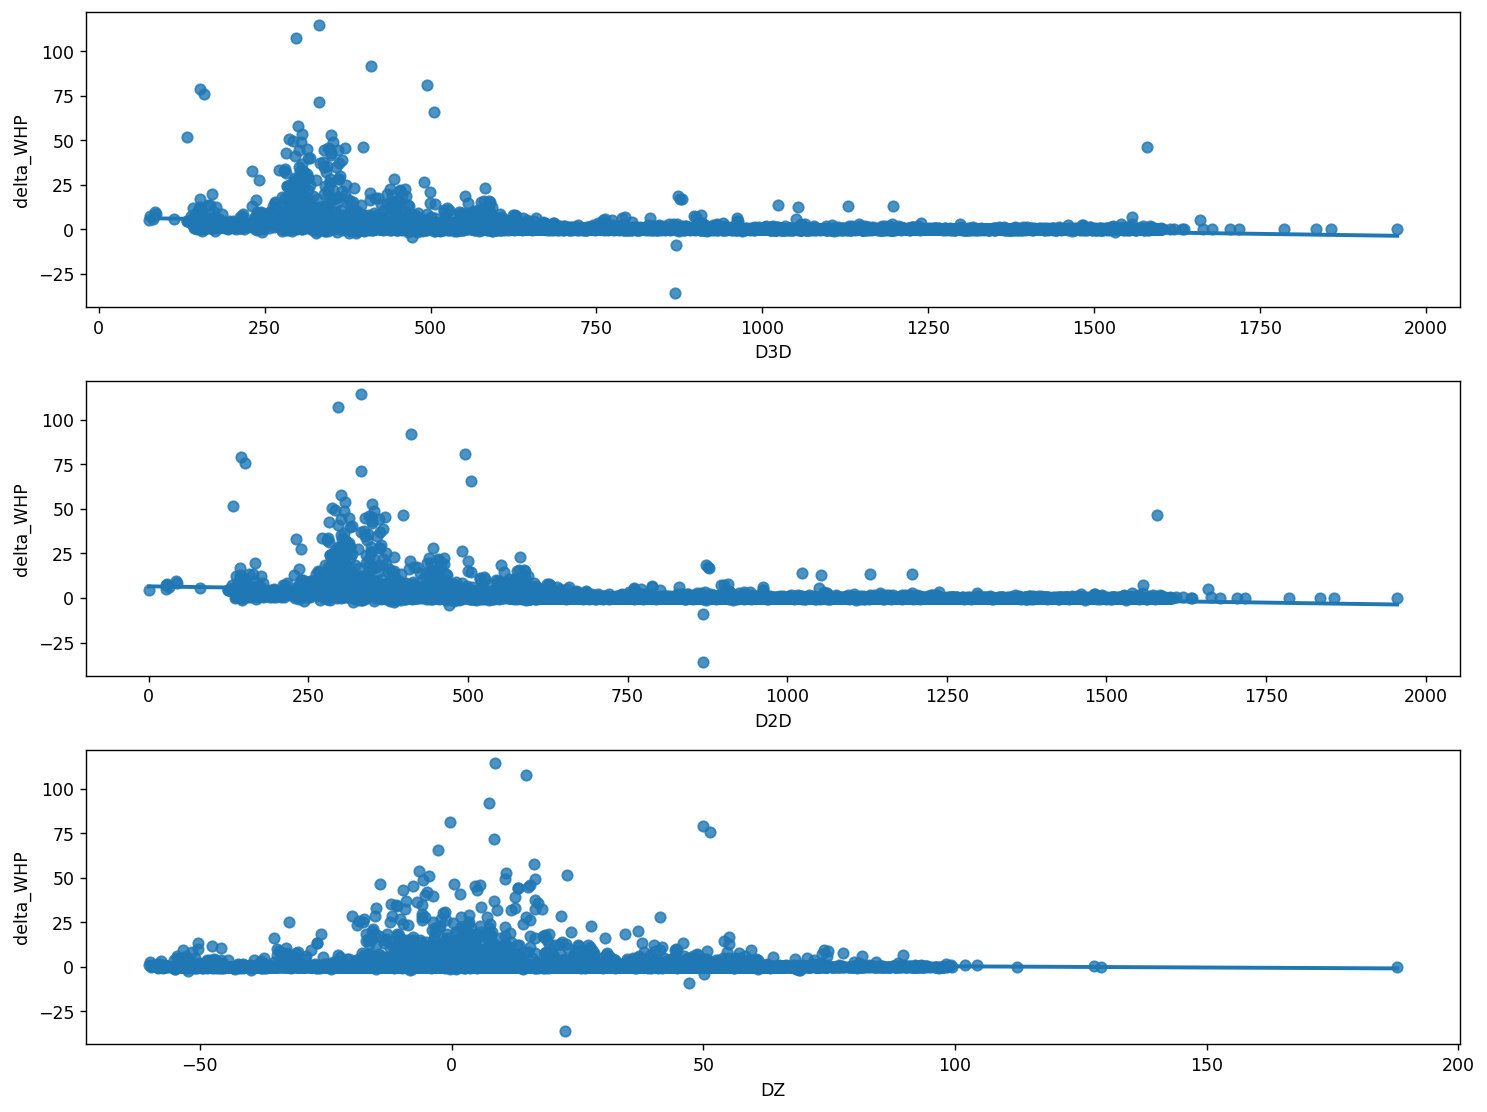

In [39]:
fig, axs = plt.subplots(nrows=3, **{"figsize": (12, 9), "dpi": 125, "facecolor": "white"})

sns.regplot(x='D3D', y='delta_WHP', data=predictions_set[predictions_set.D3D < 9000], ax=axs[0])
sns.regplot(x='D2D', y='delta_WHP', data=predictions_set, ax=axs[1])
sns.regplot(x='DZ',y='delta_WHP', data=predictions_set, ax=axs[2])

plt.tight_layout()

<AxesSubplot:xlabel='#_BARRERAS', ylabel='delta_WHP'>

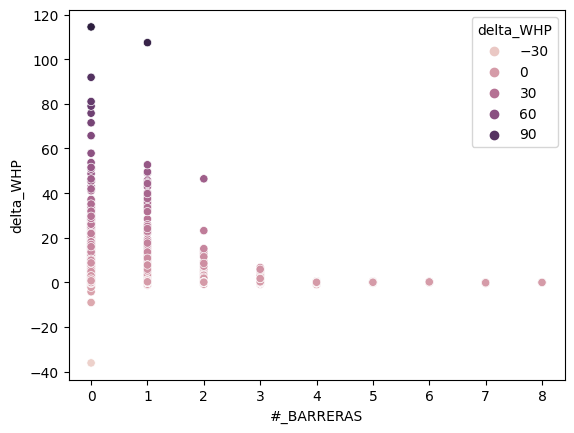

In [40]:
sns.scatterplot(
    data=predictions_set,
    x="#_BARRERAS",
    y="delta_WHP", hue="delta_WHP"
)

### Submit answer

In [42]:
predictions_set = pd.concat([predictions_set_back, predictions_set["delta_WHP"]], axis=1)

In [43]:
predictions_set.to_csv(
    EXPERIMENT_DIR / "predicciones.csv",
    columns=["ID_FILA", "delta_WHP"],
    header=False,
    index=False,
)